In [1]:
from z3 import *
import networkx as nx
import matplotlib.pyplot as plt

#Java model
java_package_name = String('java_package_name')
java_package_is_root = Bool('java_package_is_root')

#pcm model
pcm_repository_name = String('pcm_repository_name')
pcm_component_name = String('pcm_component_name')

#user choice
user_choice = Int('user_choice')


In [2]:
# pre-condition/trigger condition
trigger_condition = And(java_package_is_root, java_package_name != "")


In [3]:
# user choices path：BasicComponent, CompositeComponent, or System
basic_component_path = user_choice == 1
composite_component_path = user_choice == 2
system_path = user_choice == 3


In [4]:
# consistency condition/ post-condition
consistency_condition = Or(
    pcm_repository_name == java_package_name,  # Repository exists and matches package name
    pcm_repository_name == java_package_name + "_repo"  # Repository was created with _repo suffix
)


In [5]:
# other if case in this example
container_exists = Bool('container_exists')  # if containerpackage exist
repository_exists = Bool('repository_exists')  # if Repository exist

In [6]:
solver = Solver()

In [7]:
# Simulate operation in Reaction Language
# createOrFindArchitecturalElement
solver.add(If(container_exists,  
              pcm_repository_name == java_package_name,  
# createOrFindRepository        
              If(repository_exists, 
                 pcm_repository_name == java_package_name,  
                 pcm_repository_name == java_package_name + "_repo")))  

# user interaction
solver.add(If(user_choice == 1,
              pcm_component_name == java_package_name + "_basic",
              If(user_choice == 2,
                 pcm_component_name == java_package_name + "_composite",
                 pcm_component_name == java_package_name + "_system")))

In [8]:
# test
solver.add(java_package_name == "testPackage")
solver.add(java_package_is_root == True)
solver.add(container_exists == True)
solver.add(repository_exists == False)


print("\n=== Verifying Trigger Condition ===")
solver.push()
solver.add(trigger_condition)
if solver.check() == sat:
    print("Trigger Condition SAT:", solver.model())
else:
    print("Trigger Condition UNSAT")
solver.pop()

print("\n=== Verifying Consistency Condition ===")
solver.push()
solver.add(consistency_condition)
if solver.check() == sat:
    print("Consistency Condition SAT:", solver.model())
else:
    print("Consistency Condition UNSAT")
solver.pop()

print("\n=== Verifying User Choices ===")
user_choices_satisfied = False
for choice in [1, 2, 3]:
    solver.push()
    solver.add(user_choice == choice)
    if solver.check() == sat:
        user_choices_satisfied = True
        print(f"User choice {choice} SAT:", solver.model())
    else:
        print(f"User choice {choice} UNSAT")
    solver.pop()
    
print("\n=== Verifying All Conditions Together ===")
solver.push()
solver.add(trigger_condition)
solver.add(consistency_condition)
if user_choices_satisfied:
    print("User Choices have at least one SAT path.")
    if solver.check() == sat:
        print("All conditions satisfied:", solver.model())
    else:
        print("All conditions UNSAT due to inconsistency in Trigger or Consistency Condition.")
else:
    print("All conditions UNSAT due to invalid User Choices.")
solver.pop()


=== Verifying Trigger Condition ===
Trigger Condition SAT: [container_exists = True,
 pcm_component_name = "testPackage_basic",
 user_choice = 1,
 java_package_is_root = True,
 java_package_name = "testPackage",
 repository_exists = False,
 pcm_repository_name = "testPackage"]

=== Verifying Consistency Condition ===
Consistency Condition SAT: [container_exists = True,
 pcm_component_name = "testPackage_basic",
 user_choice = 1,
 java_package_is_root = True,
 java_package_name = "testPackage",
 repository_exists = False,
 pcm_repository_name = "testPackage"]

=== Verifying User Choices ===
User choice 1 SAT: [container_exists = True,
 pcm_component_name = "testPackage_basic",
 user_choice = 1,
 java_package_is_root = True,
 java_package_name = "testPackage",
 repository_exists = False,
 pcm_repository_name = "testPackage"]
User choice 2 SAT: [container_exists = True,
 pcm_component_name = "testPackage_composite",
 user_choice = 2,
 java_package_is_root = True,
 java_package_name = "te

In [9]:
#CFG
expr = If(container_exists,
          pcm_repository_name == java_package_name,
          If(repository_exists,
             pcm_repository_name == java_package_name,
             If(user_choice == 1,
                pcm_component_name == Concat(java_package_name, StringVal("_basic")),
                If(user_choice == 2,
                   pcm_component_name == Concat(java_package_name, StringVal("_composite")),
                   If(user_choice == 3,
                      pcm_component_name == Concat(java_package_name, StringVal("_system")),
                      pcm_repository_name == Concat(java_package_name, StringVal("_repo")))))))





def extract_cfg(expr, node_id=1):
    cfg = {}
    if expr.decl().kind() == z3.Z3_OP_ITE:  # check If-Then-Else 
        condition = expr.arg(0)  # if
        then_branch = expr.arg(1)  # then 
        else_branch = expr.arg(2)  # else 
        
        # node
        cfg[f"Node_{node_id}"] = {
            "condition": str(condition),
            "then": f"Node_{node_id * 2}",
            "else": f"Node_{node_id * 2 + 1}"
        }
        
        # then else 
        cfg.update(extract_cfg(then_branch, node_id * 2))
        cfg.update(extract_cfg(else_branch, node_id * 2 + 1))
    else:
        cfg[f"Node_{node_id}"] = {"action": str(expr)}
    
    return cfg

# extract CFG
cfg = extract_cfg(expr)
print("\nExtracted CFG:")
for node, content in cfg.items():
    print(f"{node}: {content}")



Extracted CFG:
Node_1: {'condition': 'container_exists', 'then': 'Node_2', 'else': 'Node_3'}
Node_2: {'action': 'pcm_repository_name == java_package_name'}
Node_3: {'condition': 'repository_exists', 'then': 'Node_6', 'else': 'Node_7'}
Node_6: {'action': 'pcm_repository_name == java_package_name'}
Node_7: {'condition': 'user_choice == 1', 'then': 'Node_14', 'else': 'Node_15'}
Node_14: {'action': 'pcm_component_name == Concat(java_package_name, "_basic")'}
Node_15: {'condition': 'user_choice == 2', 'then': 'Node_30', 'else': 'Node_31'}
Node_30: {'action': 'pcm_component_name ==\nConcat(java_package_name, "_composite")'}
Node_31: {'condition': 'user_choice == 3', 'then': 'Node_62', 'else': 'Node_63'}
Node_62: {'action': 'pcm_component_name == Concat(java_package_name, "_system")'}
Node_63: {'action': 'pcm_repository_name == Concat(java_package_name, "_repo")'}



Extracted CFG:
Start Node: Node_1
Node_1: IF container_exists THEN Node_2 ELSE Node_3
Node_2: ACTION: pcm_repository_name == java_package_name
Node_3: IF repository_exists THEN Node_6 ELSE Node_7
Node_6: ACTION: pcm_repository_name == java_package_name
Node_7: IF user_choice == 1 THEN Node_14 ELSE Node_15
Node_14: ACTION: pcm_component_name == Concat(java_package_name, "_basic")
Node_15: IF user_choice == 2 THEN Node_30 ELSE Node_31
Node_30: ACTION: pcm_component_name ==
Concat(java_package_name, "_composite")
Node_31: IF user_choice == 3 THEN Node_62 ELSE Node_63
Node_62: ACTION: pcm_component_name == Concat(java_package_name, "_system")
Node_63: ACTION: pcm_repository_name == Concat(java_package_name, "_repo")


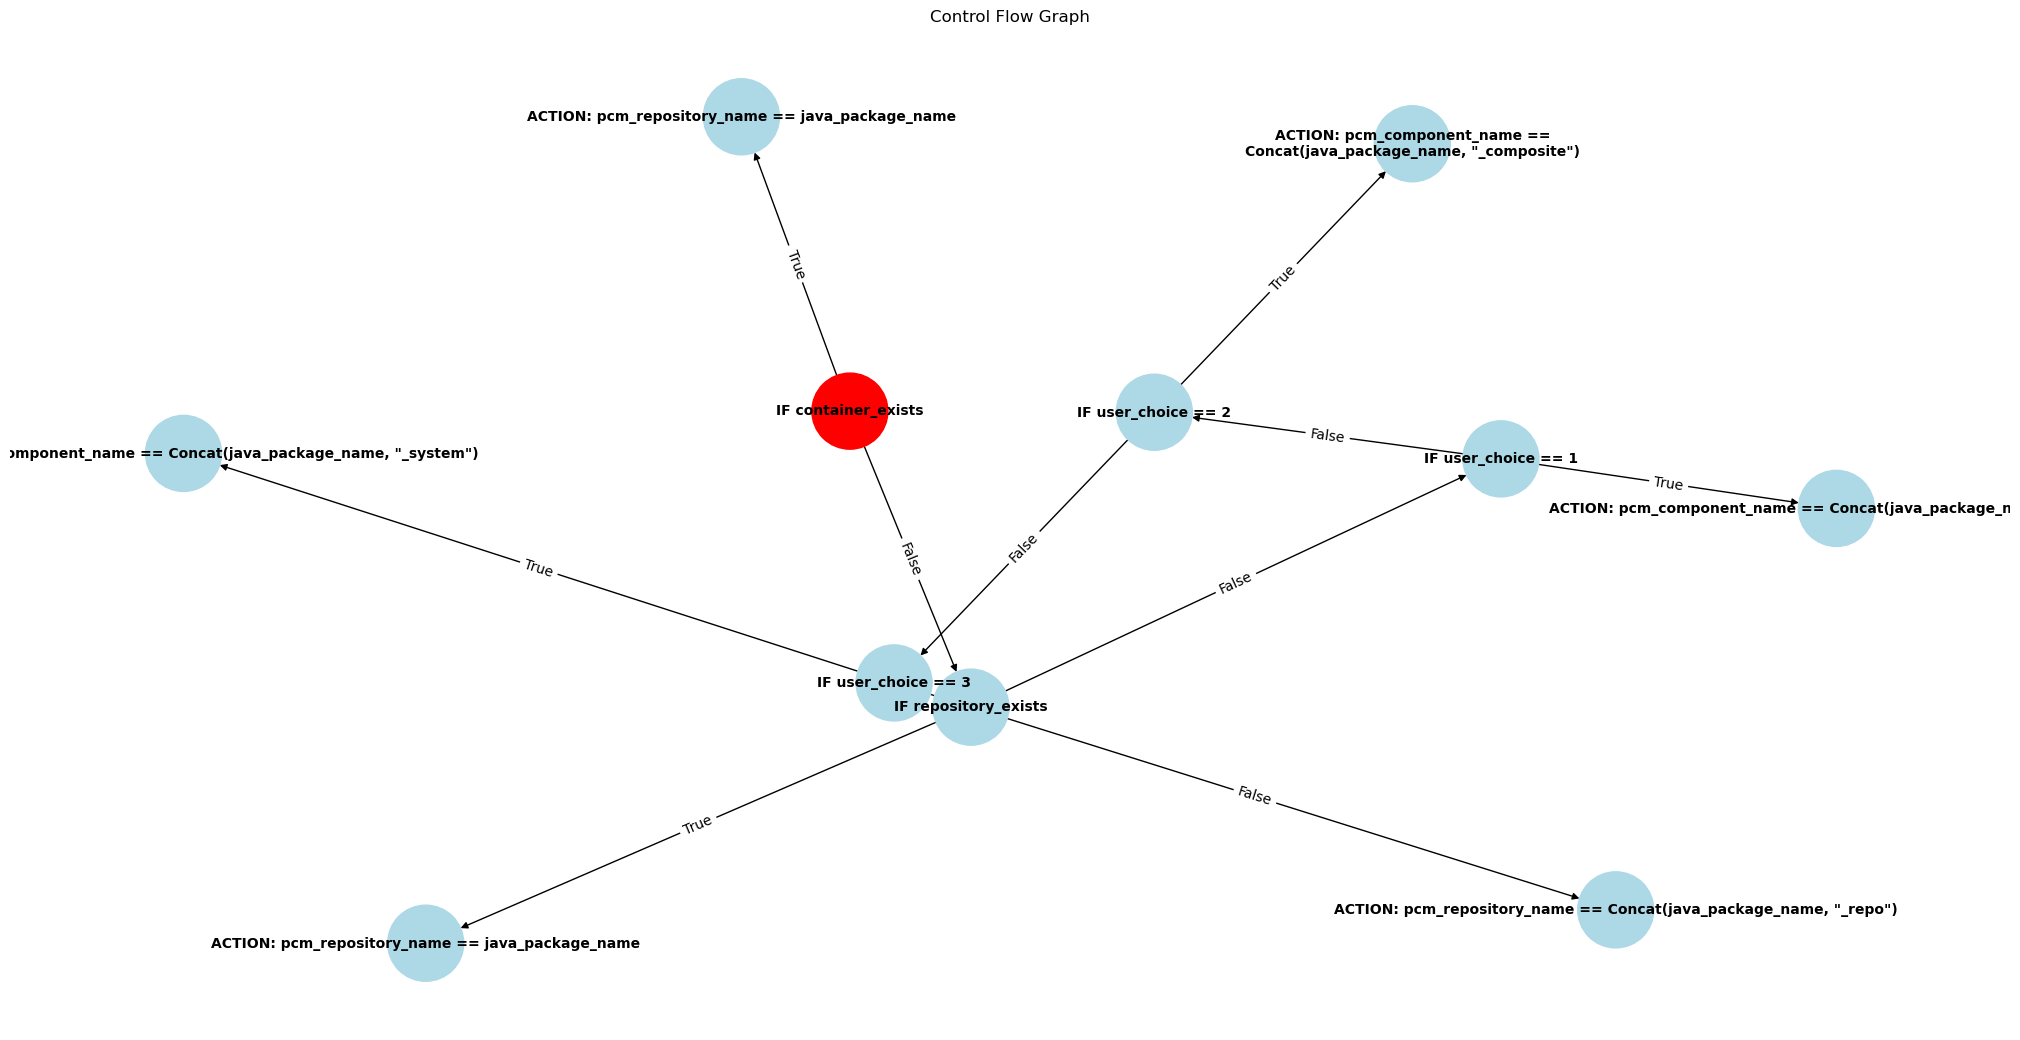

In [14]:
print("\nExtracted CFG:")
print("Start Node: Node_1")
for node, content in cfg.items():
    if "condition" in content:
        print(f"{node}: IF {content['condition']} THEN {content['then']} ELSE {content['else']}")
    elif "action" in content:
        print(f"{node}: ACTION: {content['action']}")
        
# CFG graph
def draw_cfg(cfg):
    graph = nx.DiGraph()
    for node, content in cfg.items():
        if "condition" in content:
            # Condition Node
            graph.add_node(node, label=f"IF {content['condition']}")
            graph.add_edge(node, content["then"], label="True")
            graph.add_edge(node, content["else"], label="False")
        elif "action" in content:
            # Action Node
            graph.add_node(node, label=f"ACTION: {content['action']}")
    return graph

# Paint
def plot_cfg(cfg_graph):
    # Size
    plt.figure(figsize=(20, 10))  

    # Set spring_layout 
    pos = nx.spring_layout(cfg_graph, k=1.0, iterations=200)

    # Get all nodes
    labels = nx.get_node_attributes(cfg_graph, "label")

    # Node Colors
    node_colors = ["red" if node == "Node_1" else "lightblue" for node in cfg_graph.nodes()]

    # Paint Node and connections
    nx.draw(cfg_graph, pos, with_labels=True, labels=labels, node_size=3000, 
            node_color=node_colors, font_size=10, font_weight="bold")
    
    # Label
    edge_labels = nx.get_edge_attributes(cfg_graph, "label")
    nx.draw_networkx_edge_labels(cfg_graph, pos, edge_labels=edge_labels)

    plt.title("Control Flow Graph")
    plt.show()


cfg_graph = draw_cfg(cfg)
plot_cfg(cfg_graph)